# Classification (Circle problem)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from torch import nn

## Generate a dataset

In [2]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
print(f"Features:\n{X[:5]}")
print(f"Labels:\n{y[:5]}")

Features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Labels:
[1 1 1 1 0]


In [4]:
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

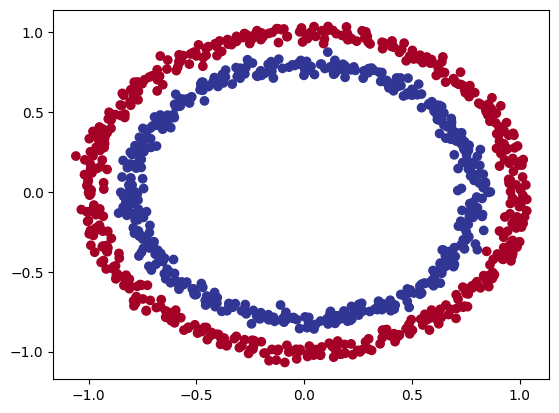

In [6]:
plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [8]:
X[:5]

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])

In [9]:
y[:5]

tensor([1., 1., 1., 1., 0.])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Build a model

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

In [14]:
model = CircleModel().to(device)
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [15]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [16]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return 100 * correct / len(y_pred)

## Train the model

In [17]:
torch.manual_seed(42)
epochs = 5000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epoch_values = []
training_accuracy_values = []
testing_accuracy_values = []
training_loss_values = []
test_loss_values = []

for epoch in range(epochs):
    # TRAINING
    model.train()

    # Forward pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # Loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_true=y_train, y_pred=y_pred)

    # Zero the gradients
    optimiser.zero_grad()

    # Loss backward
    loss.backward()

    # Optimiser step
    optimiser.step()

    # TESTING
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        epoch_values.append(epoch)
        training_accuracy_values.append(acc)
        testing_accuracy_values.append(test_acc)
        training_loss_values.append(loss.detach().numpy())
        test_loss_values.append(test_loss.detach().numpy())

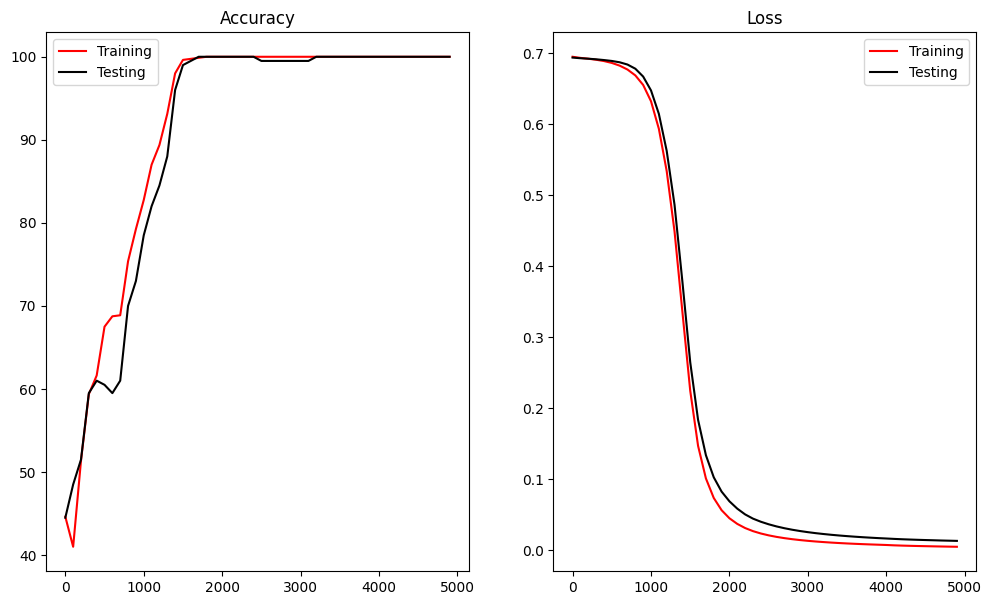

In [18]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.plot(epoch_values, training_accuracy_values, 'r', label='Training')
plt.plot(epoch_values, testing_accuracy_values, 'k', label='Testing')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_values, training_loss_values, 'r', label='Training')
plt.plot(epoch_values, test_loss_values, 'k', label='Testing')
plt.title('Loss')
plt.legend()

plt.show()

In [19]:
from helper_functions import plot_decision_boundary

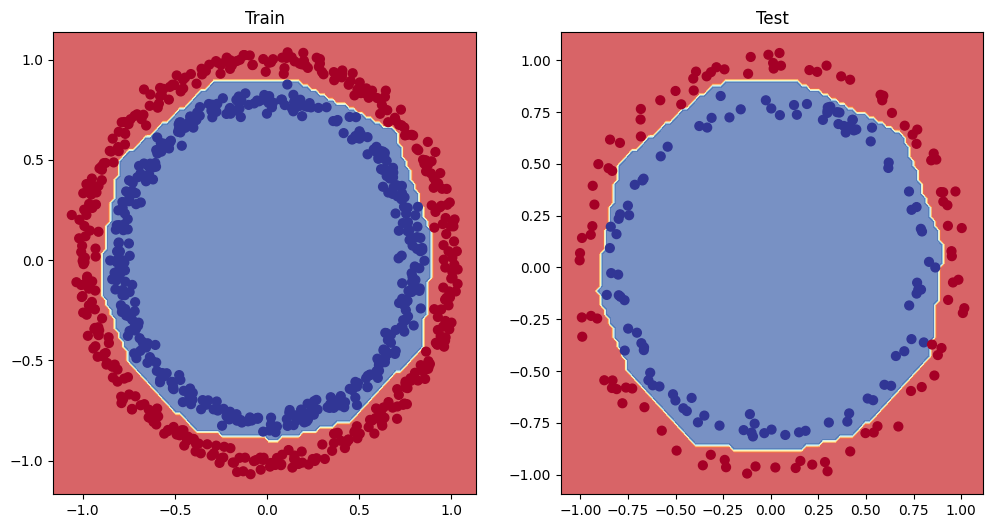

In [20]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)